In [33]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import random, os
import numpy as np
import torch

In [16]:
import tensorflow as tf

In [17]:
import torchvision
from torchvision import transforms as T

In [18]:
import matplotlib.pyplot as plt

In [19]:
def seed_everything(seed: int=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(51)

In [20]:
cifar10 = tf.keras.datasets.cifar10

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print(f"X_train.shape: {X_train.shape} \nY_train.shape: {Y_train.shape} \nX_test.shape: {X_test.shape} \nY_test.shape: {Y_test.shape}")


X_train.shape: (50000, 32, 32, 3) 
Y_train.shape: (50000, 1) 
X_test.shape: (10000, 32, 32, 3) 
Y_test.shape: (10000, 1)


One hot encoding

In [34]:
Y_train = to_categorical(Y_train, num_classes=10)
Y_test = to_categorical(Y_test, num_classes=10)

In [35]:
Y_train = Y_train.squeeze()
Y_test = Y_test.squeeze()

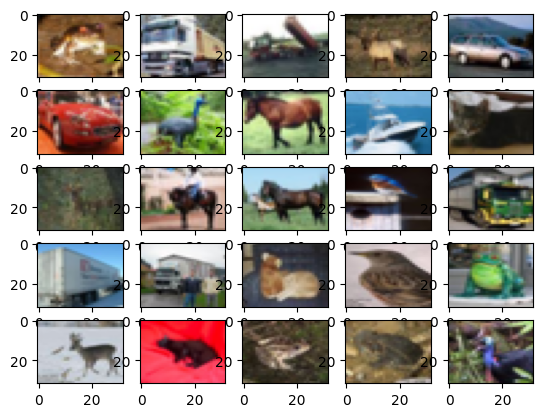

In [36]:
fig, ax = plt.subplots(5, 5)
k = 0

for i in range(5):
    for j in range(5):
        ax[i][j].imshow(X_train[k], aspect='auto')
        k += 1

plt.show()

In [37]:
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.resnet50 import preprocess_input

class CIFAR10ResNetGenerator(Sequence):
    def __init__(self, x_data, y_data, batch_size=32, shuffle=True):
        self.x = x_data
        self.y = y_data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.x))

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_x = self.x[batch_indices]
        batch_y = self.y[batch_indices]

        batch_x_resized = np.array([cv2.resize(img, (224, 224)) for img in batch_x]) #resizing the image

        batch_x_preprocessed = preprocess_input(batch_x_resized.astype(np.float32)) #(s1,s2, channels) -> (batch, s1,s2, channels)

        return batch_x_preprocessed, batch_y


In [38]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [39]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [40]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy', # changed loss
              metrics=['accuracy'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [41]:
train_gen = CIFAR10ResNetGenerator(X_train, Y_train, batch_size=32)
test_gen = CIFAR10ResNetGenerator(X_test, Y_test, batch_size=32, shuffle=False)

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=5
)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 192s 114ms/step - accuracy: 0.7550 - loss: 0.7489 - val_accuracy: 0.8714 - val_loss: 0.3605
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 175s 101ms/step - accuracy: 0.8455 - loss: 0.4459 - val_accuracy: 0.8894 - val_loss: 0.3272
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 159s 102ms/step - accuracy: 0.8596 - loss: 0.4042 - val_accuracy: 0.8975 - val_loss: 0.2985
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 159s 102ms/step - accuracy: 0.8676 - loss: 0.3850 - val_accuracy: 0.8933 - val_loss: 0.3149
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 159s 102ms/step - accuracy: 0.8706 - loss: 0.3681 - val_accuracy: 0.9033 - val_loss: 0.2857


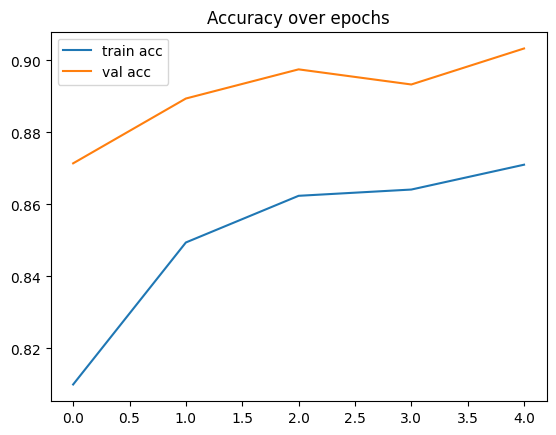

In [42]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

In [43]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


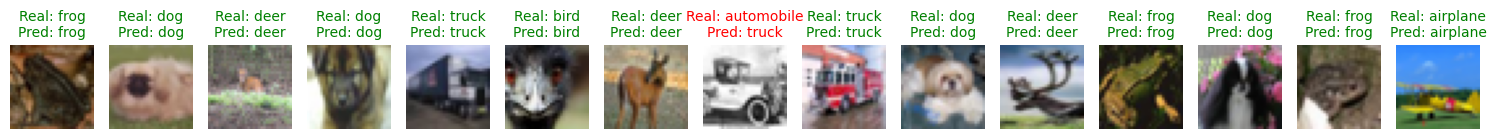

In [46]:
def label_check(image_numbers):
    fig, axes = plt.subplots(1, len(image_numbers), figsize=(15, 5))

    for i, image_number in enumerate(image_numbers):
        ax = axes[i] if len(image_numbers) > 1 else axes

        image = X_test[image_number]
        ax.imshow(image)
        ax.axis('off')

        image_resized = cv2.resize(image, (224, 224))
        image_preprocessed = preprocess_input(image_resized.astype(np.float32))
        image_input = image_preprocessed.reshape(1, 224, 224, 3)

        predicted_label_index = model.predict(image_input).argmax()
        predicted_label = labels[predicted_label_index]

        actual_label_index = np.argmax(Y_test[image_number])

        actual_label = labels[actual_label_index]

        correct = predicted_label_index == actual_label_index
        color = 'green' if correct else 'red'

        ax.set_title(f"Real: {actual_label}\nPred: {predicted_label}", fontsize=10, color=color)

    plt.tight_layout()
    plt.show()
label_check(range(30,45))

In [49]:
def label_check(image_numbers):
    fig, axes = plt.subplots(1, len(image_numbers), figsize=(15, 5))  # Adjust grid size dynamically

    for i, image_number in enumerate(image_numbers):
        ax = axes[i] if len(image_numbers) > 1 else axes

        image = X_test[image_number]
        ax.imshow(image)
        ax.axis('off')

        #resize and preprocess for ResNet
        image_resized = cv2.resize(image, (224, 224))
        image_preprocessed = preprocess_input(image_resized.astype(np.float32))
        image_input = image_preprocessed.reshape(1, 224, 224, 3)

        predicted_label_index = model.predict(image_input).argmax()
        predicted_label = labels[predicted_label_index]

        actual_label_index = np.argmax(Y_test[image_number])
        actual_label = labels[actual_label_index]

        correct = predicted_label_index == actual_label_index
        color = 'green' if correct else 'red'

        ax.set_title(f"Real: {actual_label}\nPred: {predicted_label}", fontsize=10, color=color)

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


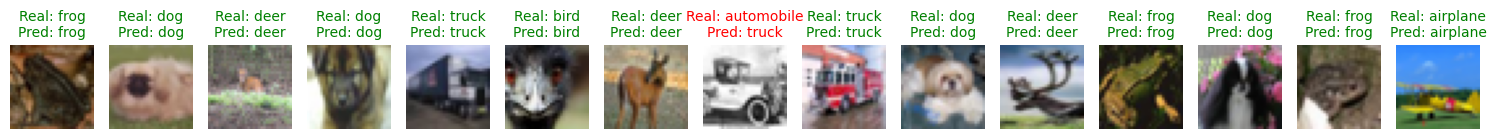

In [50]:
label_check(range(30,45))

In [ ]:
model.save("resnet_model_final.keras")

In [ ]:
model.save("resnet_model_final.h5")

In [ ]:
#retrieving the model later
#from keras.models import load_model
#model = load_model("resnet_model_3.h5")